In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

# Imports

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import torch.optim as optim
from os import listdir
from os.path import isfile, join
from tracin.tracin import (
    save_tracin_checkpoint,
    load_tracin_checkpoint,
    calculate_tracin_influence,
)
import pandas as pd
from LSTM_clean.utils import filter_and_split_data, sequence_generator, load_community_dict, get_communities, shannon_index, gini_simpson_index, num_unique
from LSTM_clean.model import LSTM 
from collections import Counter
import numpy as np
import pickle
from collections import defaultdict
import copy
from torch.optim import SGD
from lstm_wrapper import train_model, get_topk_predictions
from dataclasses import dataclass
import matplotlib.pyplot as plt
from copy import deepcopy
import math
import seaborn as sns
sns.set(style='darkgrid')

# Loading Data

In [14]:
# Data Location
# Use SAVE_PREFIX to mark different datasets
SAVE_PREFIX = ""
SAVE_FOLDER = os.path.join(os.getcwd(), "data/twitch_sequence/")
SAVE_TRAIN_NAME = SAVE_PREFIX + "train.data"
SAVE_VALID_NAME = SAVE_PREFIX + "valid.data"
SAVE_TEST_NAME = SAVE_PREFIX + "test.data"
SAVE_COMMUNITY_NAME = SAVE_PREFIX + "lstm_idx_communities.data"

In [38]:
train_data = np.load(os.path.join(SAVE_FOLDER, SAVE_TRAIN_NAME), allow_pickle=True)
valid_data = np.load(os.path.join(SAVE_FOLDER, SAVE_VALID_NAME), allow_pickle=True)
test_data = np.load(os.path.join(SAVE_FOLDER, SAVE_TEST_NAME), allow_pickle=True)

# Train a model (optional if you already have checkpoints saved in the checkpoints folder)
Configure `mitigating-filter-bubbles-final/recsys-filterbubbles/lstm_wrapper.py` with the correct output size and paths for data (from part1 notebook)

In [16]:
model, train_losses, test_losses, test_mrr, test_hits = train_model()

Device is cuda
Train: 83807, Valid: 10464
Model is  LSTM(
  (item_emb): Embedding(1743, 128, padding_idx=0)
  (LSTM): LSTM(128, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1743, bias=True)
)

Training and testing
train # = 83807, test # = 10464

Epoch 0	Train Loss: 0.014586606291348156	Test MRR: 0.013800668937230807	Test Recall@10: 0.021406727828746176	Elapsed time: 1.4650561809539795
saving checkpoint to /raid/home/myang349/mitigating-filter-bubbles-final/recsys-filterbubbles/checkpoints/lstm_checkpoint_epoch0.pt
Epoch 5	Train Loss: 0.014221881681334817	Test MRR: 0.04969632712924548	Test Recall@10: 0.11515672782874618	Elapsed time: 6.4081947803497314
Epoch 10	Train Loss: 0.013447466444752684	Test MRR: 0.053200668496117896	Test Recall@10: 0.1158256880733945	Elapsed time: 7.052039861679077
saving checkpoint to /raid/home/myang349/mitigating-filter-bubbles-final/recsys-filterbubbles/checkpoints/lstm_checkpoint_epoch10.pt
Epoch 15	Train Loss: 0.012986870266732991	Tes

# Plotting loss and performance curves

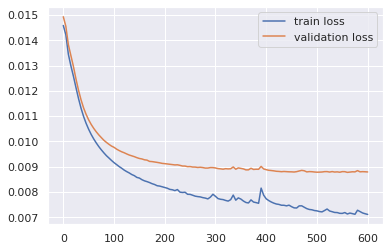

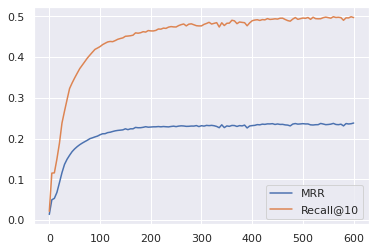

In [176]:
x = [5*i for i in range(len(train_losses))]

# plot 1
plt.plot(x, train_losses, label='train loss')
plt.plot(x, test_losses, label='validation loss')
plt.legend()
plt.show()

# plot 2
plt.plot(x, test_mrr, label='MRR')
plt.plot(x, test_hits, label='Recall@10')
plt.legend()

# Prepping the filter bubble...

## Initializing model

In [44]:
# Parameter may need to change if you re-ran all the prior pre-processing experiments
OUTPUT_SIZE=1743

device = torch.device("cuda")
print("Device is", device)
model = LSTM(input_size=128, output_size=OUTPUT_SIZE, hidden_dim=64, n_layers=1, device=device) 
model.LSTM.flatten_parameters()
optimizer = optim.SGD(model.parameters(), lr=5e-2, momentum=0.9)
model.to(device)

Device is cuda


LSTM(
  (item_emb): Embedding(1743, 128, padding_idx=0)
  (LSTM): LSTM(128, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1743, bias=True)
)

## Loading model from checkpoints

In [56]:
model, _, epoch, loss = load_tracin_checkpoint(model, optimizer, os.path.join(os.getcwd(), "checkpoints/lstm_checkpoint_epoch600.pt"))

# Filter Bubble Experiments

## Analysis Utils

In [58]:
def plot_counts(counts: dict[str, int], title='placholder_title', xlabel='x', ylabel='count') -> plt.Figure:
    """Plots a histogram from dict"""
    fig = plt.figure()

    # Creating the barplot
    plt.bar(counts.keys(), counts.values())
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

def line_plot(hm):
    # line plot
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(sorted(hm.keys()), [hm[x] for x in sorted(hm.keys())])

In [59]:
community_dict = load_community_dict(os.path.join(SAVE_FOLDER, SAVE_COMMUNITY_NAME))

## Converting prev and predictions to be equal length in community embedding

In [71]:
# Generate sequences and gt
sequences = [pt[0] for pt in valid_data]
gt = [pt[1] for pt in valid_data]

# Generate predictions
predictions = get_topk_predictions(model, sequences, k=50)

In [72]:
THRESHOLD = 0
LOOKBACK = 50

In [108]:
prev_comm = []
pred_comm = []

for i in range(len(sequences)):
    # Must be in this order, otherwise n is calculated off the wrong prev
    prev = list(reversed(sequences[i]))[:LOOKBACK]
    n = len([x for x in prev if x != 0 and x in community_dict])
    
    pred = predictions[i][:n]
    prev_comm.append(get_communities(prev, community_dict))
    pred_comm.append(get_communities(pred, community_dict))
    
for i in range(len(prev_comm)):
    assert len(prev_comm[i]) == len(pred_comm[i])
    assert THRESHOLD <= len(prev_comm[i]) <= LOOKBACK
    
print(len(sequences))
print(len(prev_comm))

10464
10464


# Distributions

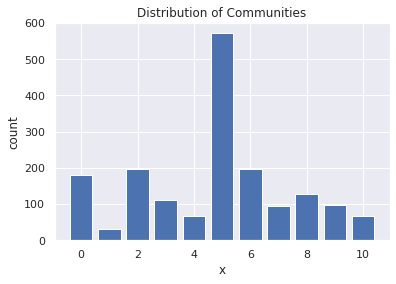

In [110]:
community_counts = Counter(community_dict.values())
plot_counts(community_counts, 'Distribution of Communities')

In [111]:
## Community Items
hm = defaultdict(int)
for pt in train_data:
    seq = pt[0]
    hm_comm = Counter(get_communities(seq, community_dict))
    for k, v in hm_comm.items():
        hm[k] += v
print(hm)

defaultdict(<class 'int'>, {8: 145723, 5: 731152, 0: 171023, 6: 388770, 4: 88152, 2: 239436, 3: 110379, 10: 41401, 7: 61153, 1: 34594, 9: 107900})


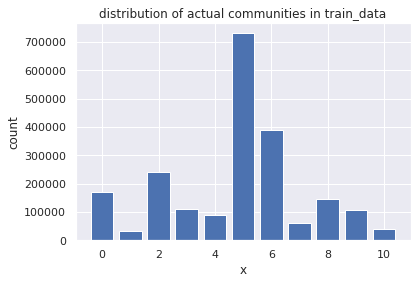

In [112]:
plot_counts(hm, 'distribution of actual communities in train_data')

defaultdict(<class 'int'>, {8: 29762, 5: 150162, 0: 37263, 6: 80541, 4: 17827, 2: 50172, 3: 23974, 10: 9183, 7: 13155, 1: 7574, 9: 23646})


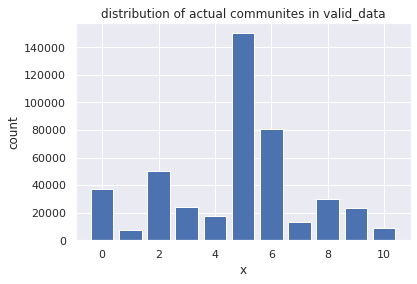

In [113]:
## Community Items
hm = defaultdict(int)
for pt in valid_data:
    seq = pt[0]
    hm_comm = Counter(get_communities(seq, community_dict))
    for k, v in hm_comm.items():
        hm[k] += v
print(hm)
plot_counts(hm, 'distribution of actual communites in valid_data')

defaultdict(<class 'int'>, {8: 676, 5: 3399, 0: 901, 4: 429, 6: 1919, 2: 1218, 10: 216, 7: 351, 9: 593, 3: 585, 1: 177})


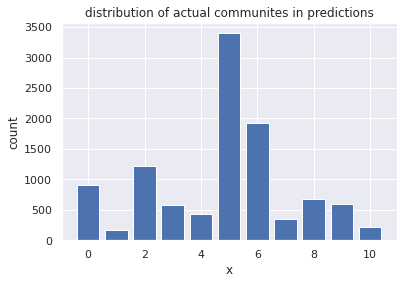

In [114]:
## Community Items
hm = defaultdict(int)
for seq in predictions:
    seq = seq[:1]
    hm_comm = Counter(get_communities(seq, community_dict))
    for k, v in hm_comm.items():
        hm[k] += v
print(hm)
plot_counts(hm, 'distribution of actual communites in predictions')

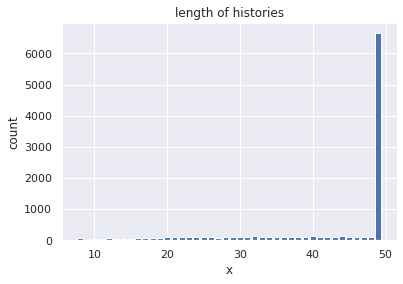

In [116]:
n = len(prev_comm)
watch_history_length_counts = Counter(len(x) for x in prev_comm)
counts = {k: watch_history_length_counts[k] for k in sorted(watch_history_length_counts)}
assert sum(counts.values()) == n
plot_counts(counts, 'length of histories')

## Relative Diversity of Points by Length (num_unique)

In [122]:
diversity_metric = num_unique

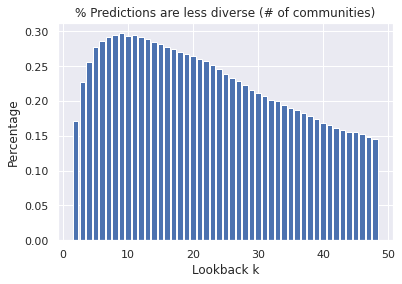

In [139]:
hm = defaultdict(list)

for i in range(len(prev_comm)):
    c1, c2 = prev_comm[i], pred_comm[i]
    for j in range(2, len(c1)):
        if diversity_metric(c1[-j:], community_dict) > diversity_metric(c2[:j], community_dict):
            hm[j].append(1)
        else:
            hm[j].append(0)

for k in hm:
    hm[k] = sum(hm[k]) /  len(hm[k])
plot_counts(hm, '% Predictions are less diverse (# of communities)', xlabel='Lookback k', ylabel='Percentage')

hm_pred_is_less_diverse = hm

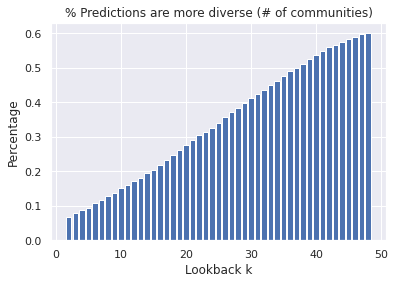

In [141]:
hm = defaultdict(list)

for i in range(len(prev_comm)):
    c1, c2 = prev_comm[i], pred_comm[i]
    for j in range(2, len(c1)):
        if diversity_metric(c1[-j:], community_dict) < diversity_metric(c2[:j], community_dict):
            hm[j].append(1)
        else:
            hm[j].append(0)

for k in hm:
    hm[k] = sum(hm[k]) /  len(hm[k])
plot_counts(hm, '% Predictions are more diverse (# of communities)', xlabel='Lookback k', ylabel='Percentage')

hm_pred_is_more_diverse = hm

Text(0, 0.5, 'Percentage')

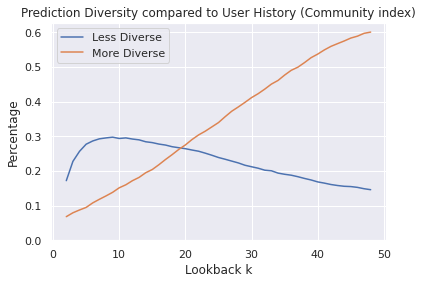

In [142]:
# Line plot
x, y = list(hm_pred_is_less_diverse.keys()), list(hm_pred_is_less_diverse.values())
x2,y2 = list(hm_pred_is_more_diverse.keys()), list(hm_pred_is_more_diverse.values())
fig = plt.figure()
ax = plt.axes()
ax.plot(sorted(x), [hm_pred_is_less_diverse[i] for i in sorted(x)], label='Less Diverse')
ax.plot(sorted(x2), [hm_pred_is_more_diverse[i] for i in sorted(x2)], label='More Diverse')
plt.legend()
ax.set_ylim(ymin=0)

# Add labels and title
plt.title("Prediction Diversity compared to User History (Community index)")
plt.xlabel("Lookback k")
plt.ylabel("Percentage")

# Relative Diversity of Points by Length (Gini-Simpson)

In [151]:
diversity_metric = gini_simpson_index

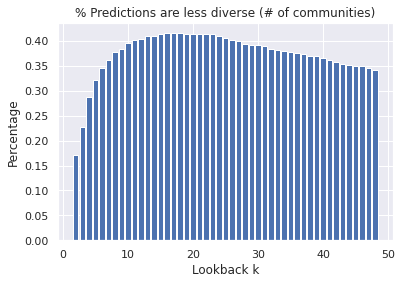

In [152]:
hm = defaultdict(list)

for i in range(len(prev_comm)):
    c1, c2 = prev_comm[i], pred_comm[i]
    for j in range(2, len(c1)):
        if diversity_metric(c1[-j:], community_dict) > diversity_metric(c2[:j], community_dict):
            hm[j].append(1)
        else:
            hm[j].append(0)

for k in hm:
    hm[k] = sum(hm[k]) /  len(hm[k])
plot_counts(hm, '% Predictions are less diverse (# of communities)', xlabel='Lookback k', ylabel='Percentage')

hm_pred_is_less_diverse = hm

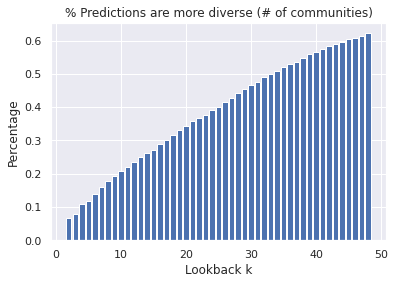

In [ ]:
hm = defaultdict(list)

for i in range(len(prev_comm)):
    c1, c2 = prev_comm[i], pred_comm[i]
    for j in range(2, len(c1)):
        if diversity_metric(c1[-j:], community_dict) < diversity_metric(c2[:j], community_dict):
            hm[j].append(1)
        else:
            hm[j].append(0)

for k in hm:
    hm[k] = sum(hm[k]) /  len(hm[k])
plot_counts(hm, '% Predictions are more diverse (# of communities)', xlabel='Lookback k', ylabel='Percentage')

hm_pred_is_more_diverse = hm

Text(0, 0.5, 'Percentage')

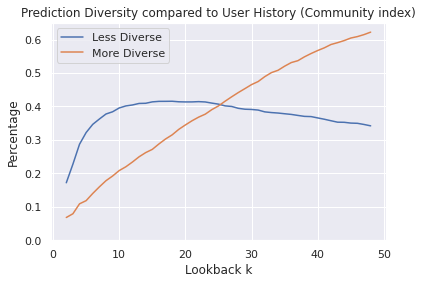

In [ ]:
# Line plot
x, y = list(hm_pred_is_less_diverse.keys()), list(hm_pred_is_less_diverse.values())
x2,y2 = list(hm_pred_is_more_diverse.keys()), list(hm_pred_is_more_diverse.values())
fig = plt.figure()
ax = plt.axes()
ax.plot(sorted(x), [hm_pred_is_less_diverse[i] for i in sorted(x)], label='Less Diverse')
ax.plot(sorted(x2), [hm_pred_is_more_diverse[i] for i in sorted(x2)], label='More Diverse')
plt.legend()
ax.set_ylim(ymin=0)

# Add labels and title
plt.title("Prediction Diversity compared to User History (Community index)")
plt.xlabel("Lookback k")
plt.ylabel("Percentage")

# Absolute Diversity of Points by length (Community Index)

In [174]:
diversity_metric = num_unique

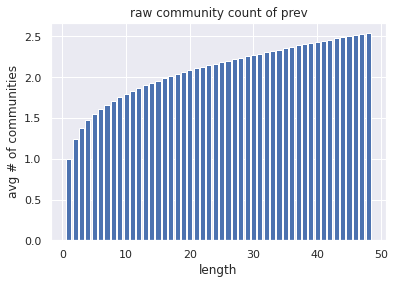

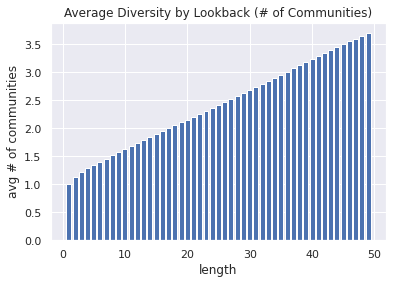

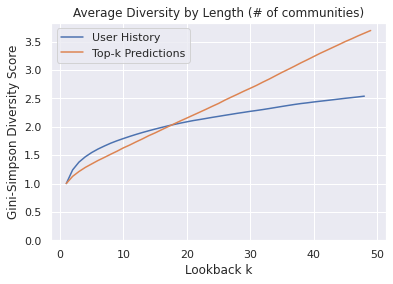

In [175]:
# full prev communities
hm = defaultdict(list)
for i in range(len(prev_comm)):
    c1 = prev_comm[i]
    for j in range(1, len(c1)):
        hm[j].append(diversity_metric(c1[:j], community_dict))
for k in hm:
    hm[k] = np.mean(hm[k])
plot_counts(hm, 'raw community count of prev', xlabel='length', ylabel='avg # of communities')
prev_communities = hm
plt.show()

# full pred communities
hm = defaultdict(list)
for pred in predictions:
    c2 = get_communities(pred, community_dict)
    for j in range(1, len(pred)):
        hm[j].append(diversity_metric(c2[:j], community_dict))
for k in hm:
    hm[k] = np.mean(hm[k])
pred_communities = hm
plot_counts(pred_communities, 'Average Diversity by Lookback (# of Communities)', xlabel='length', ylabel='avg # of communities')
plt.show()

# Line plot
x, y = list(prev_communities.keys()), list(prev_communities.values())
x2,y2 = list(pred_communities.keys()), list(pred_communities.values())
fig = plt.figure()
ax = plt.axes()
ax.plot(sorted(x), [prev_communities[i] for i in sorted(x)], label='User History')
ax.plot(sorted(x2), [pred_communities[i] for i in sorted(x2)], label='Top-k Predictions')
plt.legend()
ax.set_ylim(ymin=0)

# Add labels and title
plt.title("Average Diversity by Length (# of communities)")
plt.xlabel("Lookback k")
plt.ylabel("Gini-Simpson Diversity Score")
plt.show()

# Absolute Diversity of Points by Gini-Simpson Index

In [170]:
diversity_metric = gini_simpson_index

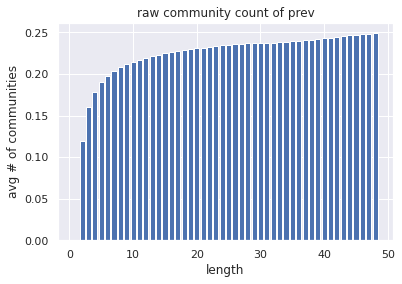

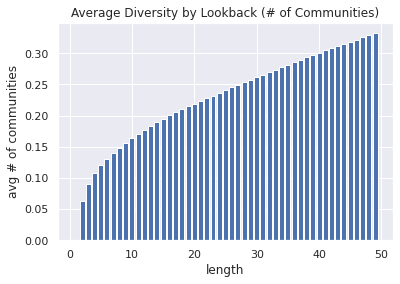

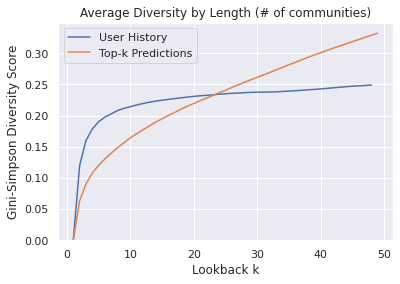

In [172]:
# full prev communities
hm = defaultdict(list)
for i in range(len(prev_comm)):
    c1 = prev_comm[i]
    for j in range(1, len(c1)):
        hm[j].append(diversity_metric(c1[:j], community_dict))
for k in hm:
    hm[k] = np.mean(hm[k])
plot_counts(hm, 'raw community count of prev', xlabel='length', ylabel='avg # of communities')
prev_communities = hm
plt.show()

# full pred communities
hm = defaultdict(list)
for pred in predictions:
    c2 = get_communities(pred, community_dict)
    for j in range(1, len(pred)):
        hm[j].append(diversity_metric(c2[:j], community_dict))
for k in hm:
    hm[k] = np.mean(hm[k])
pred_communities = hm
plot_counts(pred_communities, 'Average Diversity by Lookback (# of Communities)', xlabel='length', ylabel='avg # of communities')
plt.show()

# Line plot
x, y = list(prev_communities.keys()), list(prev_communities.values())
x2,y2 = list(pred_communities.keys()), list(pred_communities.values())
fig = plt.figure()
ax = plt.axes()
ax.plot(sorted(x), [prev_communities[i] for i in sorted(x)], label='User History')
ax.plot(sorted(x2), [pred_communities[i] for i in sorted(x2)], label='Top-k Predictions')
plt.legend()
ax.set_ylim(ymin=0)

# Add labels and title
plt.title("Average Diversity by Length (# of communities)")
plt.xlabel("Lookback k")
plt.ylabel("Gini-Simpson Diversity Score")
plt.show()